In [1]:
# Data handling
import pandas as pd
import numpy as np

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

%matplotlib inline 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Advanced AI/mortgage.csv')

df = df.drop(columns=['FMOD_DTE','FMOD_UPB','FCE_DTE','FCE_UPB','F180_DTE','F180_UPB','PRIN_FORG_UPB',
                      'FCC_DTE','ZB_DTE', 'LPI_DTE','RMW_PROCS','DISP_DT','FCC_COST','PP_COST','AR_COST',
                      'IE_COST','TAX_COST','NS_PROCS','CE_PROCS','O_PROCS','NON_INT_UPB'],axis=1)
df['REPCH_FLAG'] = df['REPCH_FLAG'].fillna('Y')
df['TRANSFER_FLAG'] = df['TRANSFER_FLAG'].fillna('Y')

#Change the vairable to binary vairbale
df['CSCORE_CB'] = np.where(df['CSCORE_C'].isnull(),0,1)
df = df.drop(['CSCORE_C'],axis=1)

#Zero Balance
df['Zero.Bal.Code'] = np.where(df['Zero.Bal.Code'].isnull(),0,1)

#Mortgage insurance percentage
df['MI_PCT'] = df['MI_PCT'].fillna(0)

df = df.drop(columns=['MI_TYPE','Servicer.Name'],axis=1)

#NUM_BO Fill na with mode   
#DTI fill na with mean
#LAST_UPB fill na with 0 
df['NUM_BO'] = df['NUM_BO'].fillna(df['NUM_BO'].mode()[0])
df['DTI'] = df['DTI'].fillna(df['DTI'].mean())
df['LAST_UPB'] = df['LAST_UPB'].fillna(0)

drop = ['Unnamed: 0','V1','LOAN_ID','ZIP_3','MSA', # meaningless ID or Code
        'ORIG_DTE','FRST_DTE','Monthly.Rpt.Prd','Maturity.Date','LAST_DTE', # useless date
        'modfg_cost', 'C_modir_cost', 'C_modfb_cost', 'Count','lpi2disp', 'zb2disp', # every row is 0
        'INT_COST', 'total_expense','total_proceeds', 'NET_LOSS', 'NET_SEV', # every row is 0
        'Total_Cost', 'Tot_Procs','Tot_Liq_Ex','MODFB_COST','MODTOT_COST','MODIR_COST', # every row is 0
        'Product.Type','Seller.Name','MOD_FLAG','DispYr', # every row is the same
        'ActYr','date', 'n', 'n.obs', 'year', 'n.year', 'n.year.max' # repeating columns
        ]
df = df.drop(columns=drop,axis=1)

df = df[(df['FTHB_FLG']!='U')&(df['PURPOSE']!='U')&(df['Delq.Status']!=999)]

# rows with null values are very few and can be deleted
df = df.dropna()

# from N/Y to 0/1
df['FTHB_FLG'] = np.where(df['FTHB_FLG']=='N',0,1)
df['RELOCATION_FLG'] = np.where(df['RELOCATION_FLG']=='N',0,1)
df['REPCH_FLAG'] = np.where(df['REPCH_FLAG']=='N',0,1)
df['TRANSFER_FLAG'] = np.where(df['TRANSFER_FLAG']=='N',0,1)

df = df.drop(['Zero.Bal.Code','REPCH_FLAG','LAST_STAT'],axis=1)

df['Delq.Status'] = np.where(df['Delq.Status']==0,0,1)
df = df.drop(['def.0','def.1','def.2','def.3','def.4','def.5'],axis=1)
df = df.drop(columns='STATE',axis=0)
df = pd.get_dummies(df, drop_first=True)

df.shape

(96352, 36)

## Sample Imbalance

In [ ]:
# train = df[df['VinYr']<=2012]
# test = df[df['VinYr']>=2013]

In [ ]:
# from imblearn.over_sampling import SMOTE

# X_train = train.drop('Delq.Status',axis=1)
# y_train = train['Delq.Status']
# X_test = test.drop('Delq.Status',axis=1)
# y_test = test['Delq.Status']

# smo = SMOTE(random_state=42)
# X_smo, y_smo = smo.fit_sample(X_train, y_train)
# X_train = pd.DataFrame(X_smo, columns=X_train.columns)
# y_train = pd.DataFrame(y_smo, columns=['Delq.Status'])

# X_smo, y_smo = smo.fit_sample(X_test, y_test)
# X_test = pd.DataFrame(X_smo, columns=X_train.columns)
# y_test = pd.DataFrame(y_smo, columns=['Delq.Status'])

In [ ]:
# pos = range(16,X_train.shape[1])
# pos2 = [] 
# col = X_train.columns[pos]
# X_train[col] = X_train[col].round()

# pos = range(16,X_test.shape[1])
# pos2 = [] 
# col = X_test.columns[pos]
# X_test[col] = X_test[col].round()

In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.feature_selection import SelectFromModel
# y_train = np.ravel(y_train)
# clf = ExtraTreesClassifier(n_estimators=50, random_state=42)
# clf = clf.fit(X_train, y_train)
# selector = SelectFromModel(clf, prefit=True)
# imp_list = X_train.columns[selector.get_support()]
# imp_list

In [ ]:
# X_train = X_train[imp_list]
# X_test = X_test[imp_list]
# X_train.head()

## K-Means

In [5]:
from sklearn import preprocessing

df2 = preprocessing.normalize(df)
# scaler = StandardScaler()
# df2 = scaler.fit_transform(df)
df2 = pd.DataFrame(df2, columns=df.columns)
#df2.to_excel('/content/drive/MyDrive/Advanced AI/data2.xlsx')

In [ ]:
#Finding optimal number of clusters
from sklearn.cluster import KMeans
from matplotlib.ticker import MaxNLocator

cost = []

for i in range(2,20):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(df)

  cost.append(kmeans.inertia_)

plt.plot(range(2,20), cost, 'bx-')
plt.xlabel("Number of K")
plt.ylabel("Squared error")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [ ]:
from sklearn.cluster import KMeans
cost = []

for i in range(2,20):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(df2)

  cost.append(kmeans.inertia_)

plt.plot(range(2,20), cost, 'bx-')
plt.xlabel("Number of K")
plt.ylabel("Squared error")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score	
# Prepare models	
kmeans = KMeans(n_clusters=5).fit(df)
normalized_kmeans = KMeans(n_clusters=5).fit(df2)

# Print results	
print('kmeans: {}'.format(silhouette_score(df, kmeans.labels_, metric='euclidean')))
print('Cosine kmeans: {}'.format(silhouette_score(df2, normalized_kmeans.labels_, metric='cosine')))

In [ ]:
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(df)
#y_kmeans = kmeans.predict(df)

In [ ]:
# df['cluster'] = y_kmeans
# df.head()

In [6]:
normalized_kmeans = KMeans(n_clusters=4, random_state=42).fit(df2)
df['cluster'] = normalized_kmeans.labels_

In [ ]:
df.groupby('cluster')['cluster'].count()

In [ ]:
df.to_excel('/content/drive/MyDrive/Advanced AI/data2.xlsx')

## Cluster Visualization

In [ ]:
def prepare_pca(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels   
    return df_matrix

def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    return df_matrix

def plot_3d(df, name='labels'):
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=name, opacity=0.5)
    fig.update_traces(marker=dict(size=3))
    fig.show()

def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)
    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()

In [ ]:
df_pca = df.drop('cluster', axis=1)

In [ ]:
pca_df = prepare_pca(2, df_pca, normalized_kmeans.labels_)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, palette="Set2")

In [ ]:
pca_df = prepare_pca(3, df_pca, normalized_kmeans.labels_)
plot_3d(df_matrix)

In [ ]:
tsne_3d_df = prepare_tsne(3, df, normalized_kmeans.labels_)	
plot_animation(tsne_3d_df, 'normalized_kmeans', 'normalized_kmeans')	

In [ ]:
plot_3d(tsne_3d_df)

In [ ]:
plot_3d(tsne_3d_df, name='normalized_kmeans')

## Cutomer Characteristics

## Random Forest

In [7]:
df.head()

,ORIG_RT,ORIG_AMT,ORIG_TRM,OLTV,OCLTV,NUM_BO,DTI,CSCORE_B,FTHB_FLG,NUM_UNIT,MI_PCT,RELOCATION_FLG,LAST_RT,LAST_UPB,Loan.Age,Months.To.Legal.Mat,Adj.Month.To.Mat,Delq.Status,TRANSFER_FLAG,CSCORE_MN,ORIG_VAL,MODTRM_CHNG,MODUPB_CHNG,Fin_UPB,VinYr,CSCORE_CB,ORIG_CHN_C,ORIG_CHN_R,PURPOSE_P,PURPOSE_R,PROP_TYP_CP,PROP_TYP_MH,PROP_TYP_PU,PROP_TYP_SF,OCC_STAT_P,OCC_STAT_S,cluster
0,2.875,450000.0,180,19,19,1.0,28.0,802.0,0,1,0.0,0,2.875,0.00,2,178,175,0,0,802.0,2.368421e+06,0.0,0.0,0.00,2016.0,0,0,1,0,1,0,0,0,1,1,0,2
1,5.500,30000.0,120,13,13,2.0,11.0,758.0,0,1,0.0,0,5.500,0.00,3,117,101,0,1,758.0,2.307692e+05,0.0,0.0,0.00,2003.0,1,0,1,1,0,0,0,0,1,1,0,2
2,3.875,115000.0,360,85,85,1.0,31.0,751.0,1,1,12.0,0,3.875,113208.71,9,351,351,0,0,751.0,1.352941e+05,0.0,0.0,113208.71,2016.0,0,1,0,1,0,0,0,0,1,1,0,1
3,5.750,88000.0,360,90,90,2.0,26.0,773.0,0,1,25.0,0,5.750,86979.02,8,352,352,0,1,762.0,9.777778e+04,0.0,0.0,86979.02,2004.0,1,0,1,1,0,0,0,0,1,0,0,1
4,3.500,290000.0,360,90,90,1.0,45.0,792.0,1,1,25.0,0,3.500,0.00,4,356,354,0,0,792.0,3.222222e+05,0.0,0.0,0.00,2016.0,0,0,1,1,0,0,0,0,1,1,0,0


In [8]:
train = df[df['VinYr']<=2012]
test = df[df['VinYr']>=2013]
train.shape, test.shape

((62416, 37), (33936, 37))

In [18]:
train.groupby('cluster')[['OLTV','OCLTV','LAST_UPB','Fin_UPB','Loan.Age']].agg(['mean', 'min', 'max']) 

OLTV              OCLTV  ...    Fin_UPB  Loan.Age        
              mean min max       mean  ...        max      mean min max
cluster                                ...                             
0        77.653272  60  97  78.367340  ...  122721.83  2.533021  -1  11
1        76.876735  58  97  77.668122  ...  780158.64  7.878997   5  12
2        43.574343   5  59  45.250000  ...  445313.09  2.555414  -1  11
3        43.998894  19  82  45.510669  ...  768678.98  7.827881   5  11

[4 rows x 15 columns]

In [9]:
train_pct = train.groupby('cluster')['cluster'].count().to_frame(name='count').reset_index()
train_pct['sum'] = 62416
train_pct['percentage'] = (train_pct['count']/train_pct['sum']).round(3)
train_pct[['cluster', 'percentage']]

,cluster,percentage
0,0,0.431
1,1,0.305
2,2,0.163
3,3,0.101


In [10]:
test_pct = test.groupby('cluster')['cluster'].count().to_frame(name='count').reset_index()
test_pct['sum'] = 33936
test_pct['percentage'] = (test_pct['count']/test_pct['sum']).round(2)
test_pct[['cluster', 'percentage']]

,cluster,percentage
0,0,0.46
1,1,0.37
2,2,0.10
3,3,0.07


In [11]:
X_train = train.drop('cluster',axis=1)
y_train = train['cluster']
X_test = test.drop('cluster',axis=1)
y_test = test['cluster']

In [12]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report

model = RandomForestClassifier(max_depth=8, random_state=42, n_estimators=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15650
           1       0.99      1.00      1.00     12415
           2       1.00      1.00      1.00      3364
           3       0.99      0.98      0.98      2507

    accuracy                           1.00     33936
   macro avg       1.00      0.99      0.99     33936
weighted avg       1.00      1.00      1.00     33936



In [ ]:
d = {
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}
dt_imp = pd.DataFrame(d)
dt_imp = dt_imp.sort_values('Importance', ascending=False)
dt_imp.index = range(len(dt_imp))
(dt_imp['Importance']!=0).sum(), (dt_imp['Importance']==0).sum()

In [ ]:
dt_imp[dt_imp['Importance']==0].Feature

Text(0.5, 1.0, 'Top 10 Important Features')

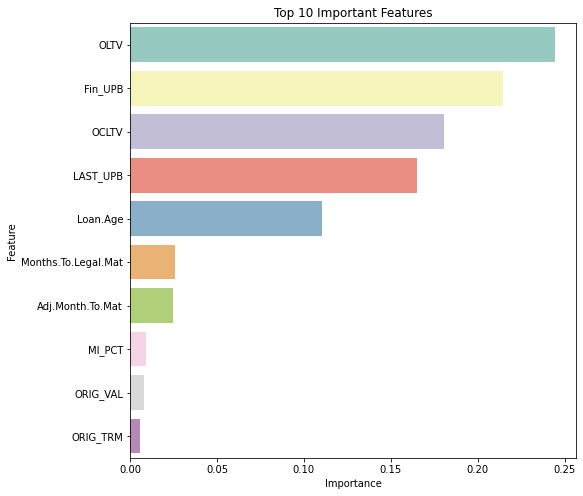

In [ ]:
plt.figure(figsize=(8,8))
sns.barplot(data=dt_imp[dt_imp['Importance']!=0][:10], y='Feature', x='Importance', palette='Set3')
plt.title('Top 10 Important Features')

## Correlation Heatmap

In [ ]:
def plot_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

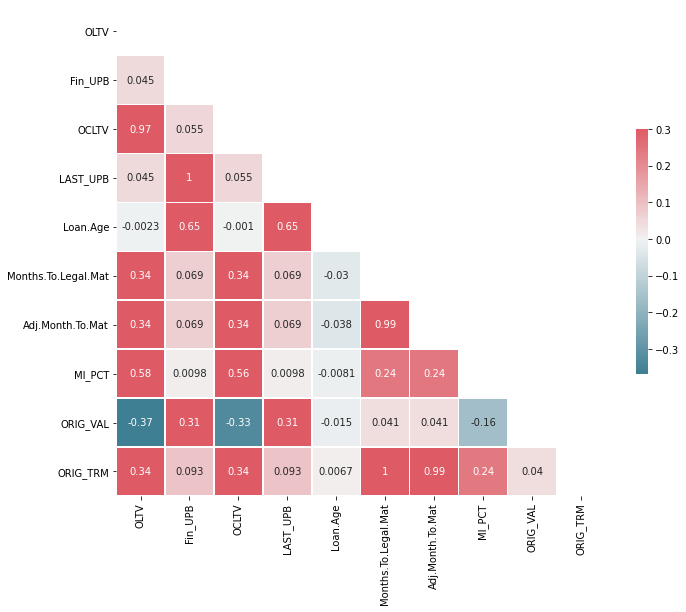

In [ ]:
features= dt_imp.sort_values(by='Importance',ascending=False)
features = features.iloc[:10,]
features = features['Feature'].to_list()
corMax = df[features]

plot_corr(corMax)

## PDP plots

In [ ]:
!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

In [ ]:
features= dt_imp.sort_values(by='Importance',ascending=False)
features = features.iloc[:10,]
features = features['Feature'].to_list()

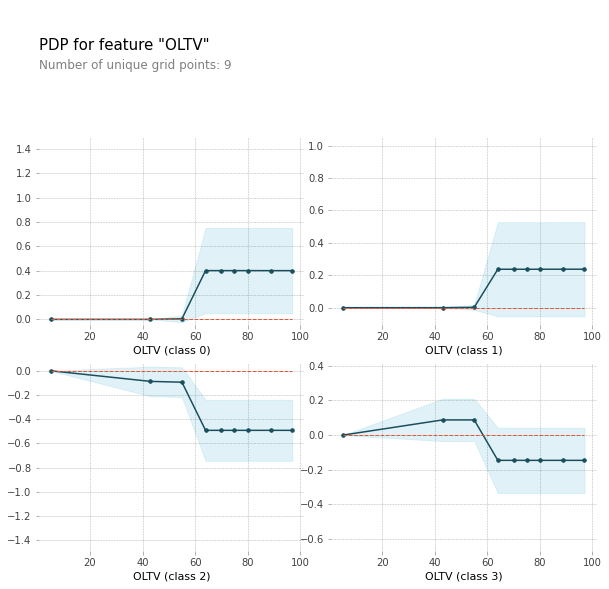

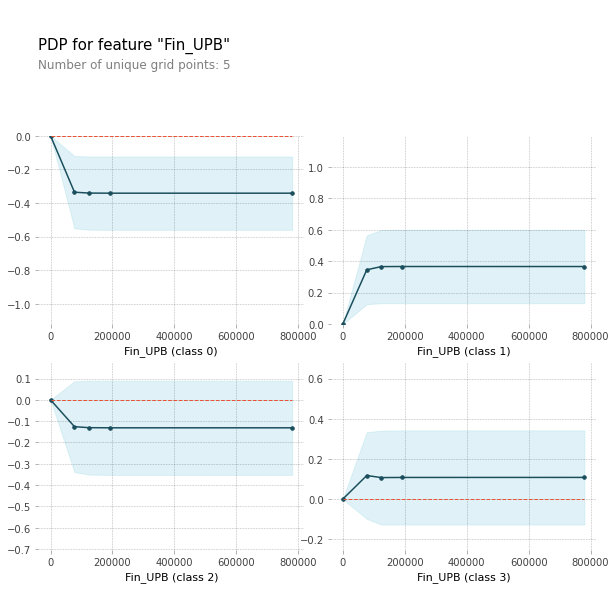

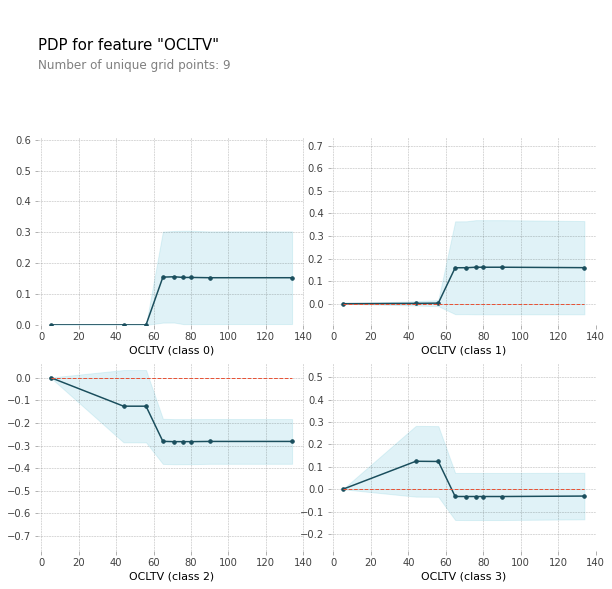

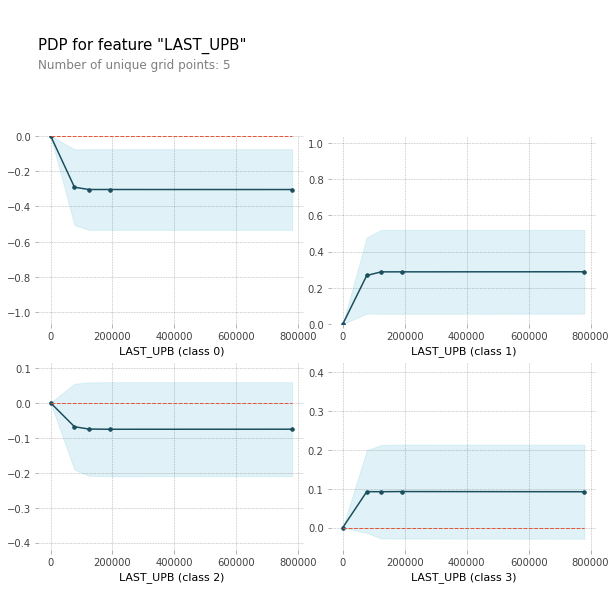

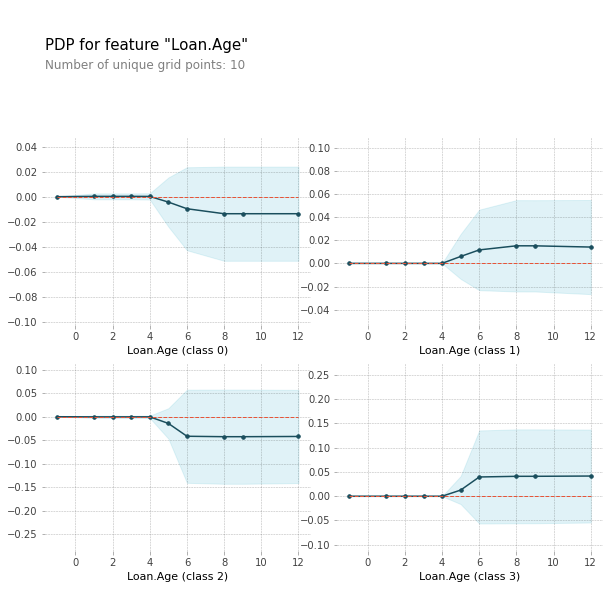

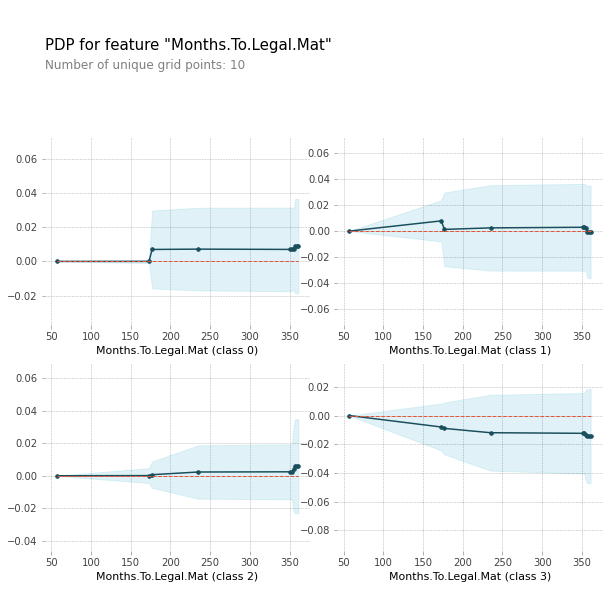

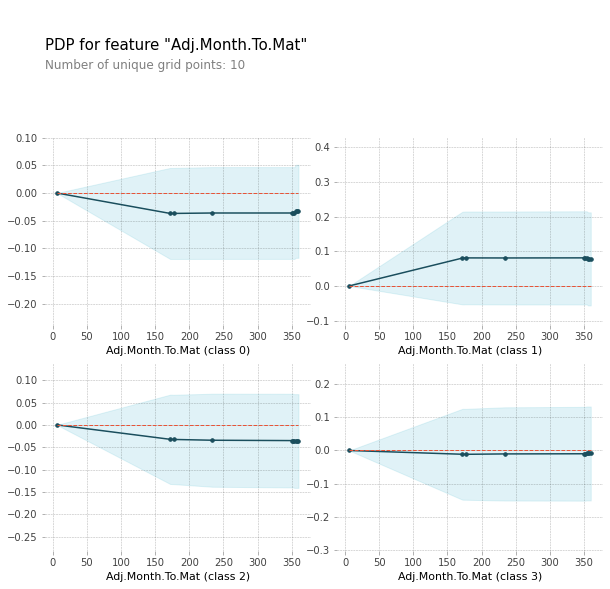

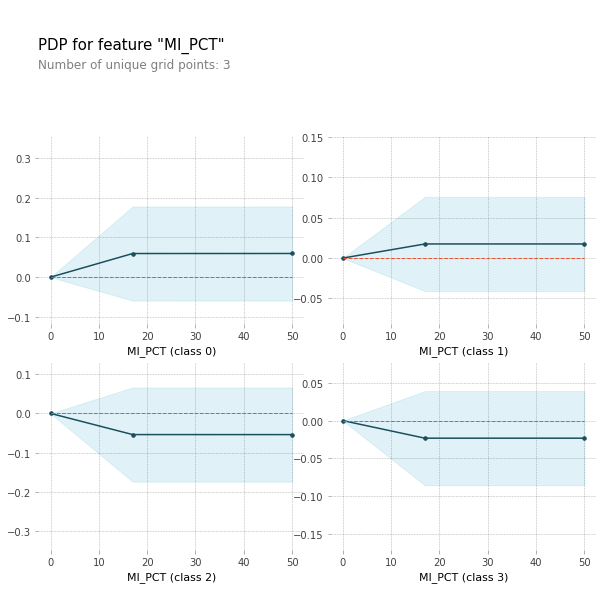

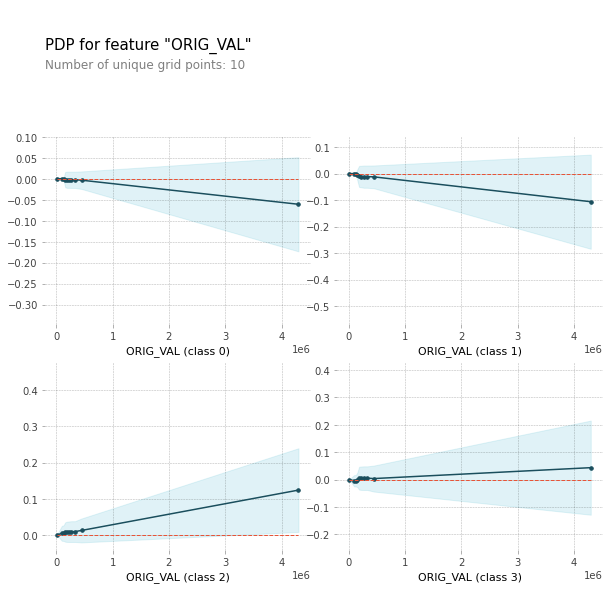

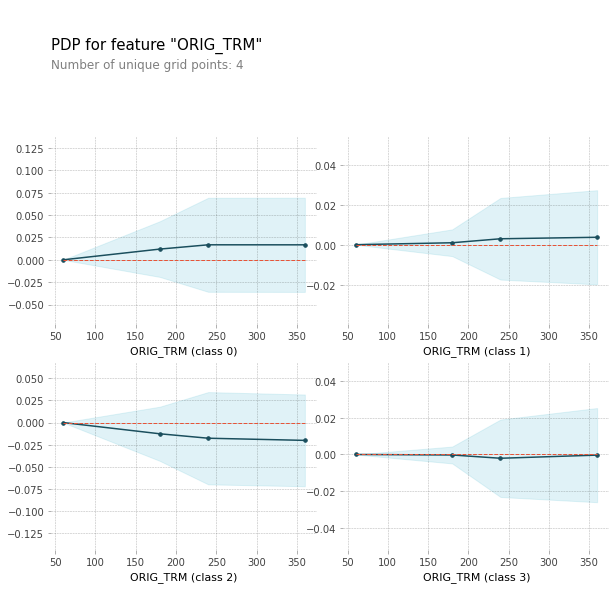

In [ ]:
for i in range(len(features)):
  pdp_goals = pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns, feature=features[i])
  pdp.pdp_plot(pdp_goals, features[i], figsize=(10,10), center=True)
  plt.show()

## ICE plots


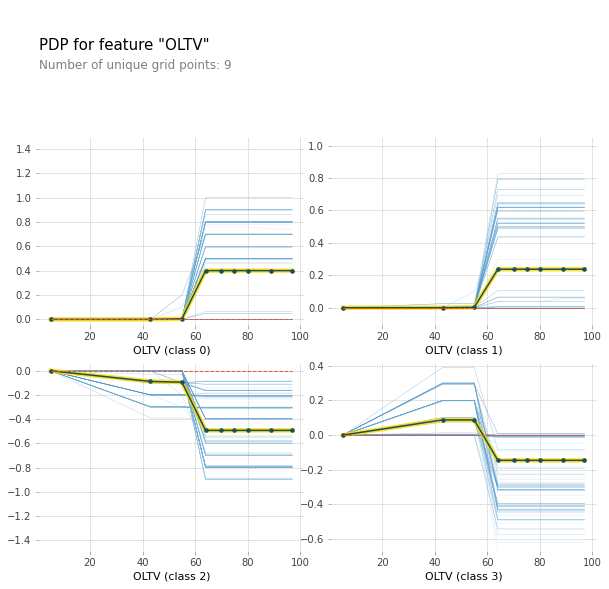

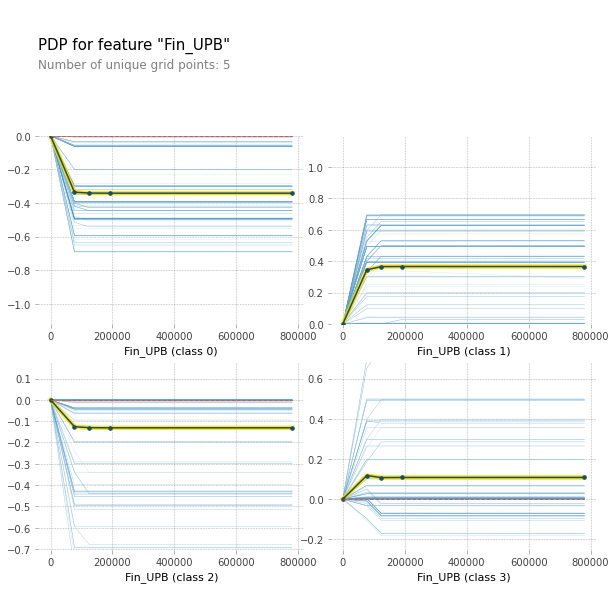

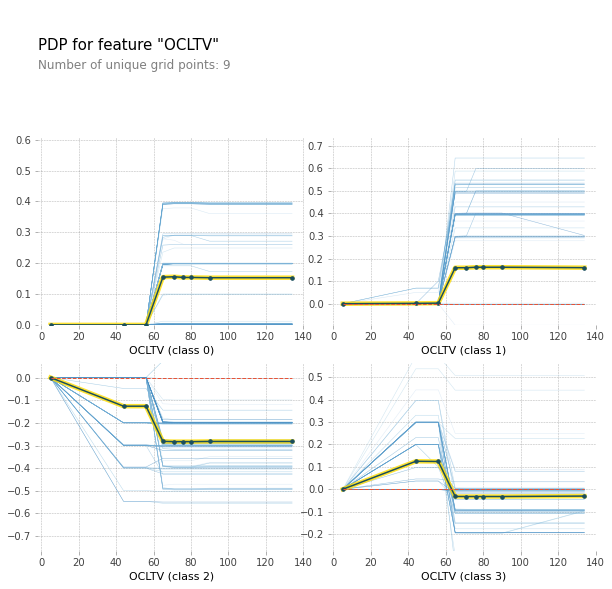

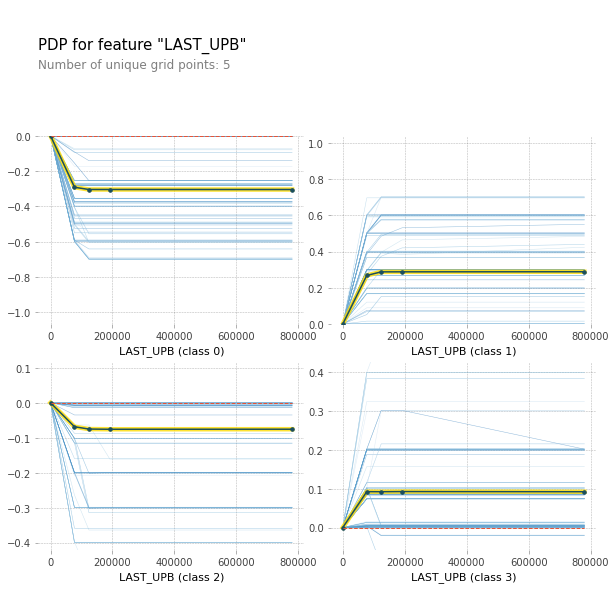

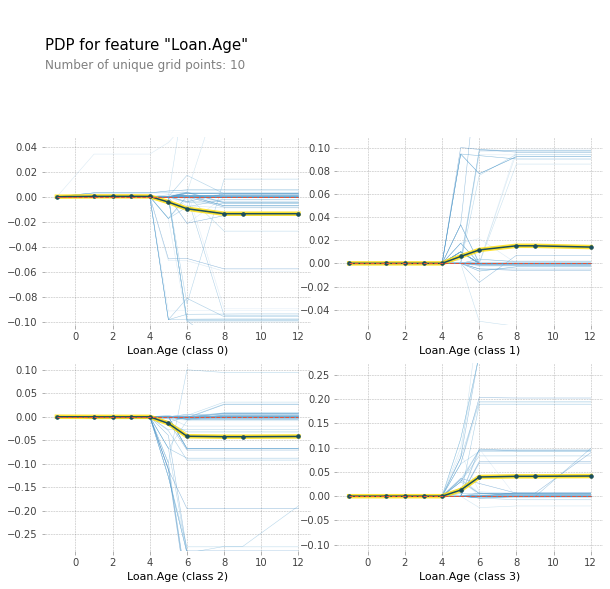

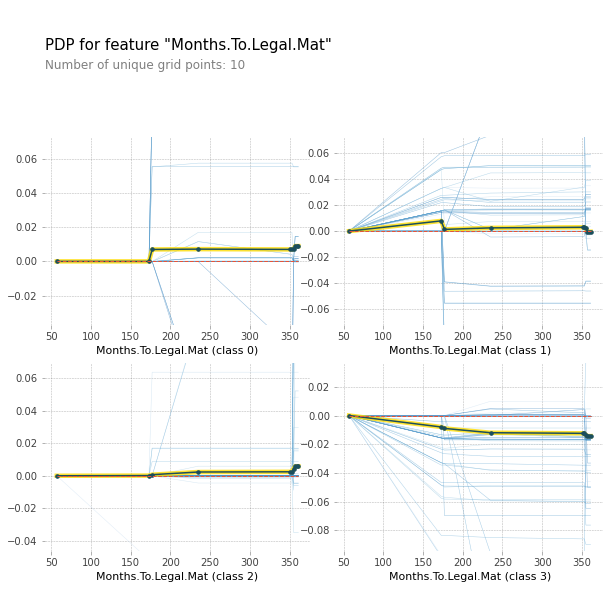

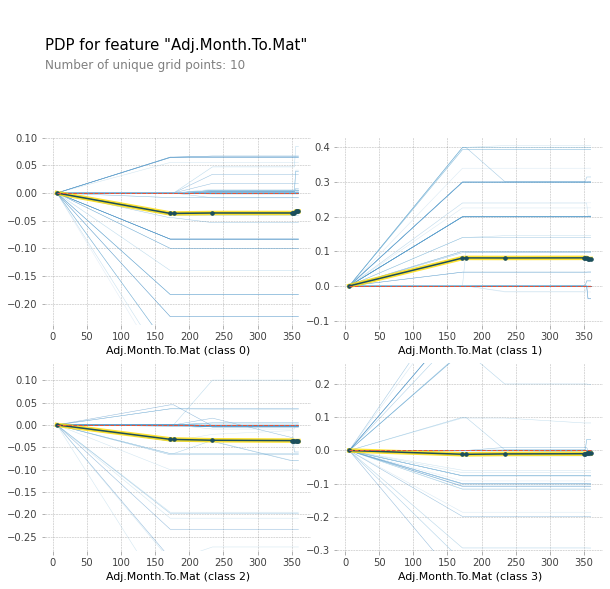

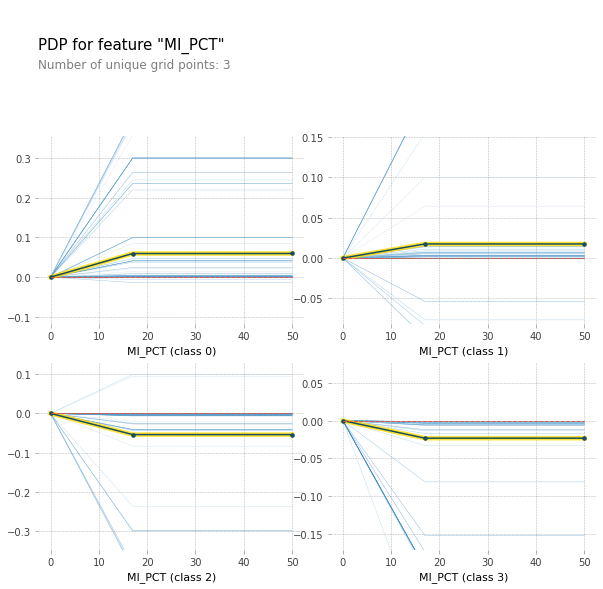

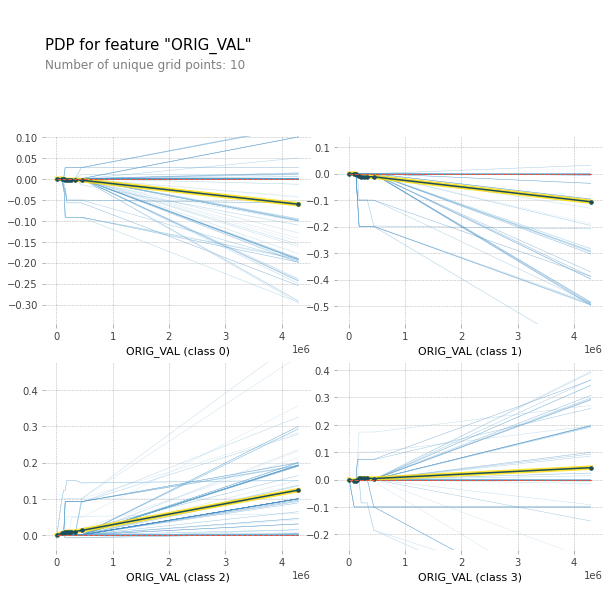

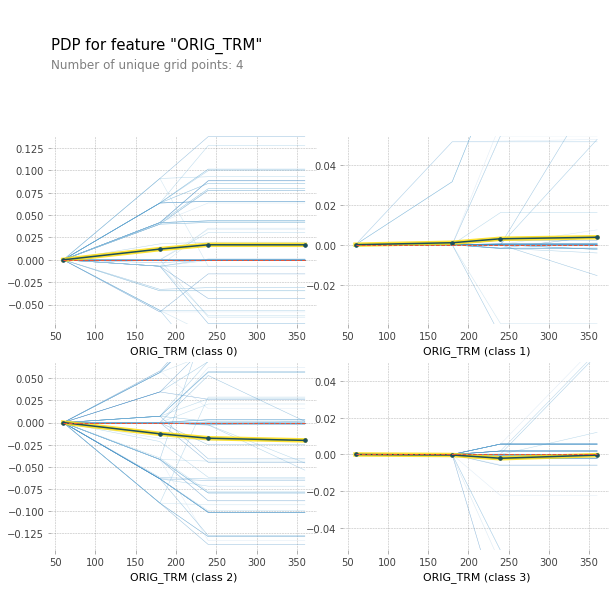

In [ ]:
for i in range(len(features)):
  pdp_goals = pdp.pdp_isolate(model=model, dataset=X_train, model_features=X_train.columns, feature=features[i])
  pdp.pdp_plot(pdp_goals,features[i],figsize=(10,10),plot_lines=True,frac_to_plot=100)
  plt.show()

## ALE plots

In [ ]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

In [ ]:
from alepython import ale_plot
for i in range(len(features)):
  ale_plot(model, X_train, features[i])

## LIME

In [ ]:
!pip install lime
import lime
import lime.lime_tabular
from sklearn.metrics import classification_report

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['MEDV'], verbose=True, mode='regression')

In [ ]:
# Choose the 5th instance and use it to predict the results
j = 5
exp = explainer.explain_instance(X_test.values[j], model.predict, num_features=10)

In [ ]:
exp.show_in_notebook(show_table=True)

In [ ]:
exp.as_list()

In [ ]:
j = 10
exp = explainer.explain_instance(X_test.values[j], model.predict, num_features=6)

In [ ]:
exp.show_in_notebook(show_table=True)

## SHAP

In [ ]:
!pip install shap
import shap
shap.initjs() 

     |████████████████████████████████| 358kB 6.3MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491622 sha256=13bbe2a1c7b5036928a692e4b5177f024909d4bce66fba0f74aaad8dbd4465fe
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

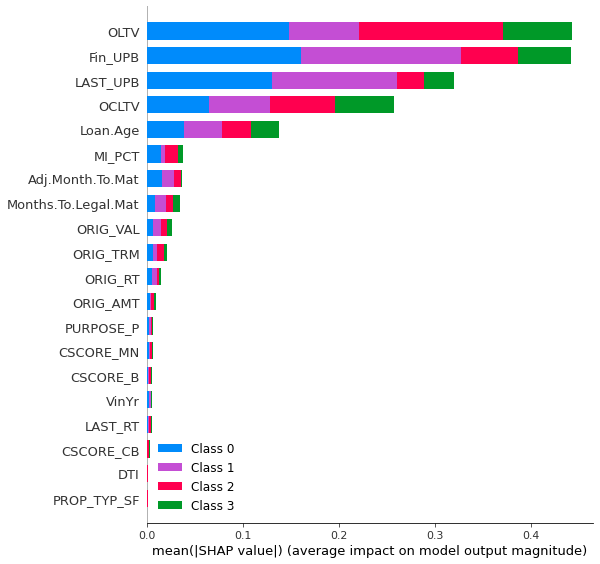

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

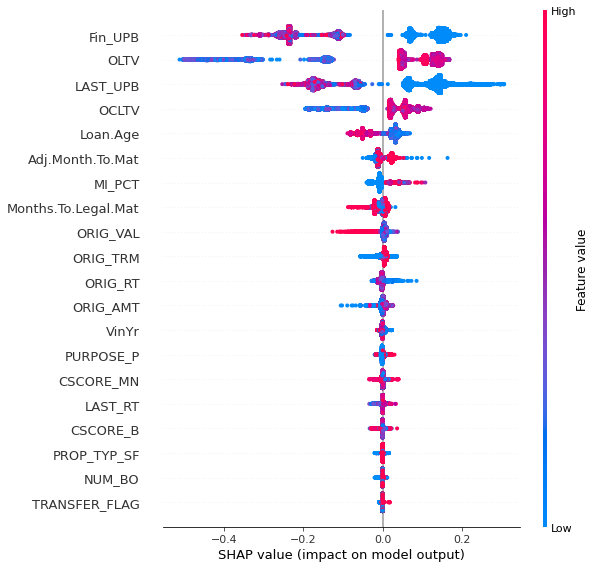

In [ ]:
shap.summary_plot(shap_values[0], X_train)

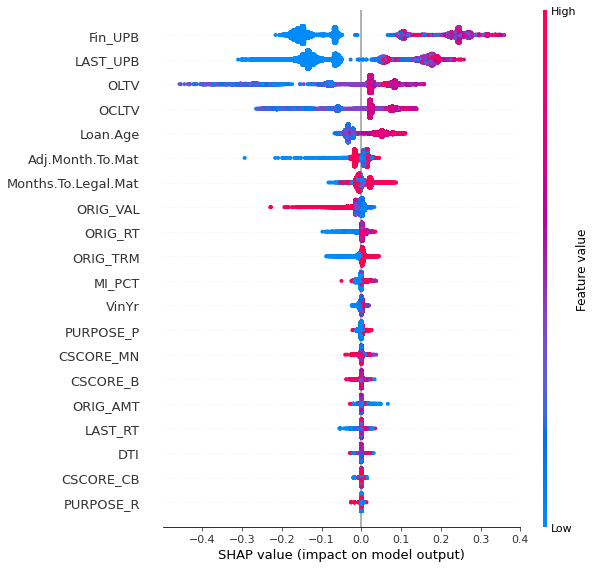

In [ ]:
shap.summary_plot(shap_values[1], X_train)

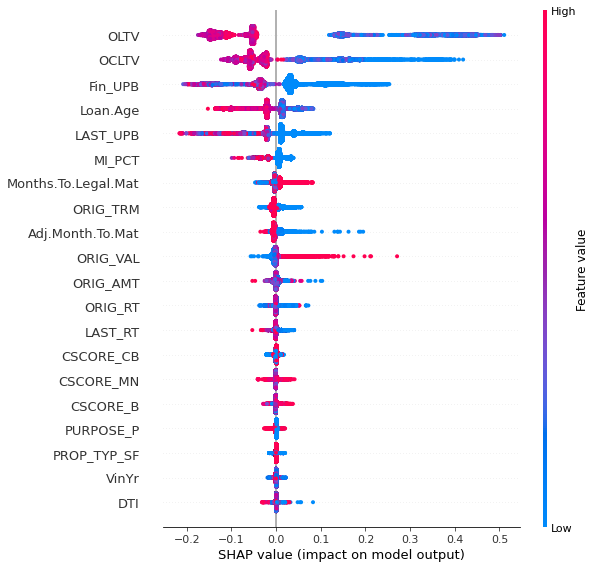

In [ ]:
shap.summary_plot(shap_values[2], X_train)

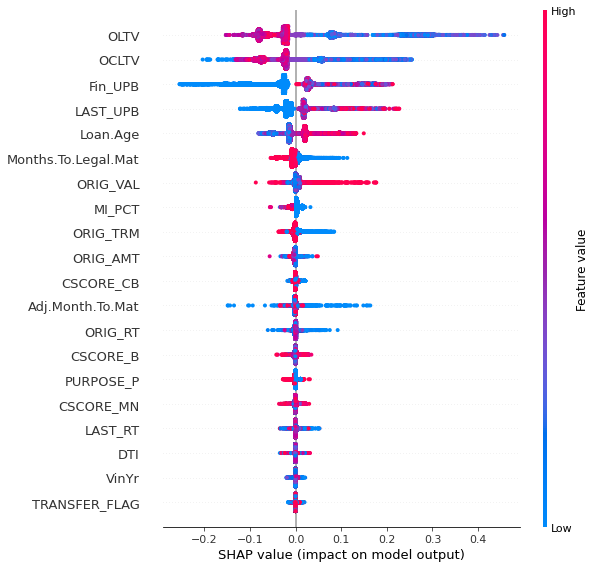

In [ ]:
shap.summary_plot(shap_values[3], X_train)

In [ ]:
top_cols = X_train.columns[np.argsort(shap_values[0].std(0))[::-1]][:10]
for col in top_cols:
    shap.dependence_plot(col, shap_values[1], X_train)